In [41]:
import spacy
nlp=spacy.load('pl_spacy_model_morfeusz')
#nlp = spacy.load('pl_spacy_model')

In [18]:
from PIL import Image 
import pytesseract 
import sys 
import os
import pandas as pd
import cv2 
import os
from PIL import Image
from pytesseract import image_to_string
import numpy as np
from matplotlib import pyplot as plt
import os
from autocorrect import Speller
from matplotlib.pyplot import figure


In [19]:
spell = Speller('pl')

In [20]:
def fig_prepare(image):
  
  kernel_3x3 = np.ones((3, 3), np.float32) / 9

  kernel_sharpening = np.array([[-1,-1,-1], 
                                [-1, 9,-1],
                                [-1,-1,-1]])

  blurred = cv2.filter2D(image, -1, kernel_3x3)
  sharpened = cv2.filter2D(blurred, -1, kernel_sharpening)

  blurred = cv2.filter2D(sharpened, -1, kernel_3x3)
  sharpened = cv2.filter2D(blurred, -1, kernel_sharpening)

  lower=np.array([0,0,0])
  upper=np.array([100,100,100])

  mask = cv2.inRange(sharpened, lower, upper)
  
  return 255-mask

In [21]:
def text_from_file(image):
  image_correct=fig_prepare(image)
  custom_config_letters = r'--oem 3 --psm 3'
  custom_config_digits = r'--oem 3 --psm 3 outputbase digits'
  return (image_to_string(image_correct, lang='pol',config=custom_config_letters)),(image_to_string(image_correct, lang='pol',config=custom_config_digits))

In [22]:
def text_from_image(image):
  image_correct=image
  custom_config_letters = r'--oem 3 --psm 3'
  custom_config_digits = r'--oem 3 --psm 3 outputbase digits'
  return (image_to_string(image_correct, lang='pol',config=custom_config_letters)),(image_to_string(image_correct, lang='pol',config=custom_config_digits))

In [23]:
import re
def hasNumbers(inputString):
   return any(char.isdigit() for char in inputString)

In [24]:
def mask_from_cropped(cropped):
          kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
          dilated = cv2.dilate(cropped, kernel)
          eroded=cv2.erode(dilated,kernel)

          kernel_3x3 = np.ones((3, 3), np.float32) / 9

          kernel_sharpening = np.array([[-1,-1,-1], 
                                [-1, 9,-1],
                                [-1,-1,-1]])

          blurred = cv2.filter2D(eroded, -1, kernel_3x3)
          sharpened = cv2.filter2D(blurred, -1, kernel_sharpening)

          blurred = cv2.filter2D(sharpened, -1, kernel_3x3)
          sharpened = cv2.filter2D(blurred, -1, kernel_sharpening)

          

          lower=np.array([0,0,0])
          upper=np.array([130,130,130])

          return cv2.inRange(sharpened, lower, upper)

In [25]:
def countrurs(gray,ythresh): 
  thresh=255-gray
  # use morphology erode to blur horizontally
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (151, 3))
  morph = cv2.morphologyEx(thresh, cv2.MORPH_DILATE, kernel)

  # use morphology open to remove thin lines from dotted lines
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 17))
  morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kernel)


  # find contours
  cntrs = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cntrs = cntrs[0] if len(cntrs) == 2 else cntrs[1]

  # find the topmost box
  for c in cntrs:
        box = cv2.boundingRect(c)
        x,y,w,h = box
        if y < ythresh:
            topbox = box
            ythresh = y
  return cntrs[::-1],topbox

In [27]:
def string_clean(word):
  word_new=word
  for char in word:
    if char.isalnum():
      pass
    else:
      word_new = word.replace(char, "")
  return word_new

In [37]:
file_d=open('/home/kacper/Pobrane/slowa.txt','r')
dictionary=[]
while file_d.readline():
    dictionary.append(file_d.readline().replace('\n',''))

In [42]:
import morfeusz2
morf = morfeusz2.Morfeusz()

In [98]:
def morfeusz(word):
    text=morf.analyse(word)
    for t in text:
        if t[2][1] in dictionary:
            return 1
    return 0

In [102]:
morfeusz('pax')

0

In [396]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display



In [405]:
def Correct(_,log=True):
        with out:
         logic[0]=log
def notCorrect(_):
    #print("not correct readout")
    return Correct(_,False)

In [407]:

def display_question():
    button_Correct=widgets.Button(description='correct')
    button_notCorrect=widgets.Button(description='not correct')
    out=widgets.Output()

    logic=[True]

    button_Correct.on_click(Correct)
    button_notCorrect.on_click(notCorrect)
    buttons = widgets.HBox((button_Correct,button_notCorrect))
    widgets.VBox((buttons,out))
    display(buttons) 


In [408]:
display_question

<function __main__.display_question()>

In [377]:
output = widgets.Output()
logic=[True]
@output.capture(clear_output=False,wait=True) # based on https://github.com/jupyter-widgets/ipywidgets/issues/1846 and https://ipywidgets.readthedocs.io/en/latest/examples/Output%20Widget.html
def sayHello(logic):
    logic=[False]
    print("You have pushed the button, congratulations I guess.")

run_button = widgets.Button(
      description = 'continue'
)
print("Hello, please push the continue button")
run_button.on_click(sayHello)
display(run_button)
output

Hello, please push the continue button


Button(description='continue', style=ButtonStyle())

Output()

In [378]:
logic[0]

True

In [448]:
from functools import wraps
def yield_for_change(widget, attribute):
    """Pause a generator to wait for a widget change event.

    This is a decorator for a generator function which pauses the generator on yield
    until the given widget attribute changes. The new value of the attribute is
    sent to the generator and is the value of the yield.
    """
    def f(iterator):
        @wraps(iterator)
        def inner():
            i = iterator()
            def next_i(change):
                try:
                    i.send(change.new)
                except StopIteration as e:
                    widget.unobserve(next_i, attribute)
            widget.observe(next_i, attribute)
            # start the generator
            next(i)
        return inner
    return f

In [557]:
def fsentences(sentences):
    print('start fsentences')
    letter,word_new,sentence,sentence_new='','','',''
    w_len,exists,correctness=[],[],[0,0,0,0]

    for sen in sentences:
                print('start loop in fsentences')
                for s in sen[0]:
                  if s.isspace():
                    word_new=word_new.join(letter)
                    
                    word_new=string_clean(word_new)
                    
                    if word_new:
                      w_len.append(len(word_new))
                      if morfeusz(word_new):
                        exists.append(1)
                      else:
                        exists.append(0)
                    letter=''
                    sentence=sentence+' '+word_new
                    word_new=''
                  else:
                    letter=letter+s
                sentence_new=sentence_new.join(sentence)
                np_w_len=np.array(w_len)
                np_exists=np.array(exists)
              
                if w_len:
                    print('full sentence',sentence_new)
                    print('numeric analysis ','std ',np.std(np_w_len),'mean ',np.mean(np_w_len),'length ',np_w_len.shape)
                    print('dictionary analysis ','std ',np.std(np_exists),'mean ',np.mean(np_exists),'length ',np_exists.shape)
                sentence=''
                sentence_new=''
                w_len=[]
                exists=[]
                print('next method\n')

In [558]:
def analyze_figures(cropped_board,mask_board):
   print('start analyze')
   correctnes_list=[]
   if re.search('[a-zA-Z]',image_to_string(cropped_board,lang='pol',config = r'--oem 3 --psm 3')) or re.search('[a-zA-Z]',image_to_string(mask_board, lang='pol',config= r'--oem 3 --psm 3')):
              print('image to analyze')
              string_dig_crop=image_to_string(cropped_board,lang='pol',config = r'outputbase digits')#r'--oem 3 --psm 3 outputbase digits'
              print('string_dig_crop')
              string_dig_mask=image_to_string(mask_board, lang='pol',config = r'outputbase digits')
              print('string_dig_mask')
              string_let_crop=image_to_string(cropped_board,lang='pol')
              print('string_let_crop')
              string_let_mask=image_to_string(mask_board, lang='pol')
              print('string_let_mask')
              x0,x1,x2,x3=0,1,2,3
              print('x0,x1,x2,x3=')
              sentences=[[string_dig_crop,x0],[string_dig_mask,x1],[string_let_crop,x2],[string_let_mask,x3]]
              print('sentences ',sentences)
              fsentences(sentences)
              print('figures printing')
              figure(figsize=(20,50))
              plt.imshow(cropped_board)
              plt.show() 
              figure(figsize=(20,50))
              plt.imshow(mask_board)
              plt.show() 
              print('figures printed')
   else:
        print('not analysing')

In [527]:
file='/home/kacper/resolution500/fig1.jpg'
image = cv2.imread(file)
gray=fig_prepare(image)

image = cv2.imread(file)
result = gray.copy()
ythresh=1000
cntrs,topbox=countrurs(gray,ythresh)
i=0
images=[]
for c in cntrs:
      box = cv2.boundingRect(c)
      if box != topbox:
          i=i+1
          x,y,w,h = box
          cv2.rectangle(result, (x, y), (x+w, y+h), (0, 0, 255), 2)
          cropped = image[y:y + h, x:x + w]  
    
          mask = mask_from_cropped(cropped)
          board=30
          cropped_board = cv2.copyMakeBorder( cropped, board,board, board, board,cv2.BORDER_CONSTANT, value=[190, 190, 190])
          mask_board = cv2.copyMakeBorder( mask, board, board, board, board, cv2.BORDER_CONSTANT)
          im=[cropped_board,mask_board ]
          images.append(im)  
          #correctnes_list=analyze_figures(cropped_board,mask_board)

In [528]:
#stworz interface
#otworz katalog, potem kolejne pliki w petli
#dla konretnego pliku stworz liste konturow
# dla konkretnego kontura okresl poprawnosc i zapisz tabele

In [540]:
from IPython.display import clear_output

In [559]:
def wait_for_change(widget):
    future = asyncio.Future()
    def getvalue(change):
        future.set_result(change.description)
        widget.on_click(getvalue, remove=True) 
        # we need to free up the binding to getvalue to avoid an InvalidState error
        # buttons don't support unobserve
        # so use `remove=True` 
    widget.on_click(getvalue)
    return future

async def f():
    for i in list_to_tag:
        print("going to tag {}".format(len(i)))
        cropped_board,mask_board =i
        analyze_figures(cropped_board,mask_board)
        
        x = await wait_for_change(button)
        print("tagged {} with {}".format(len(i), x))
        #clear_output(wait=True) czyszczenie do douczenia

button = Button(description="correct?")
#create list of files/images/folders
#list_to_tag = ["one", "two", "three", "four"]
list_to_tag = images

In [560]:
len(list_to_tag)

78

Button(description='correct?', style=ButtonStyle())

going to tag 2
start analyze
not analysing
tagged 2 with correct?
going to tag 2
start analyze
not analysing
tagged 2 with correct?
going to tag 2
start analyze
not analysing
tagged 2 with correct?
going to tag 2
start analyze
image to analyze
string_dig_crop
string_dig_mask
string_let_crop
string_let_mask
x0,x1,x2,x3=
sentences  [['\x0c', 0], ['\x0c', 1], ['IZ\n\x0c', 2], ['\x0c', 3]]
start fsentences
start loop in fsentences
next method

start loop in fsentences
next method

start loop in fsentences
full sentence  IZ 
numeric analysis  std  0.0 mean  2.0 length  (1,)
dictionary analysis  std  0.0 mean  0.0 length  (1,)
next method

start loop in fsentences
next method

figures printing


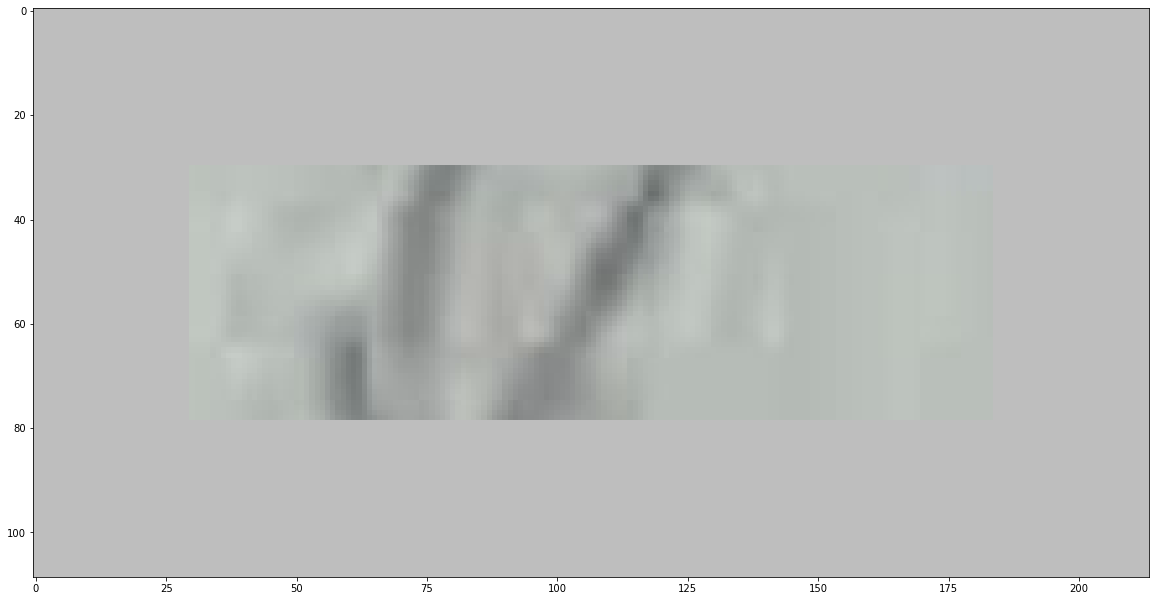

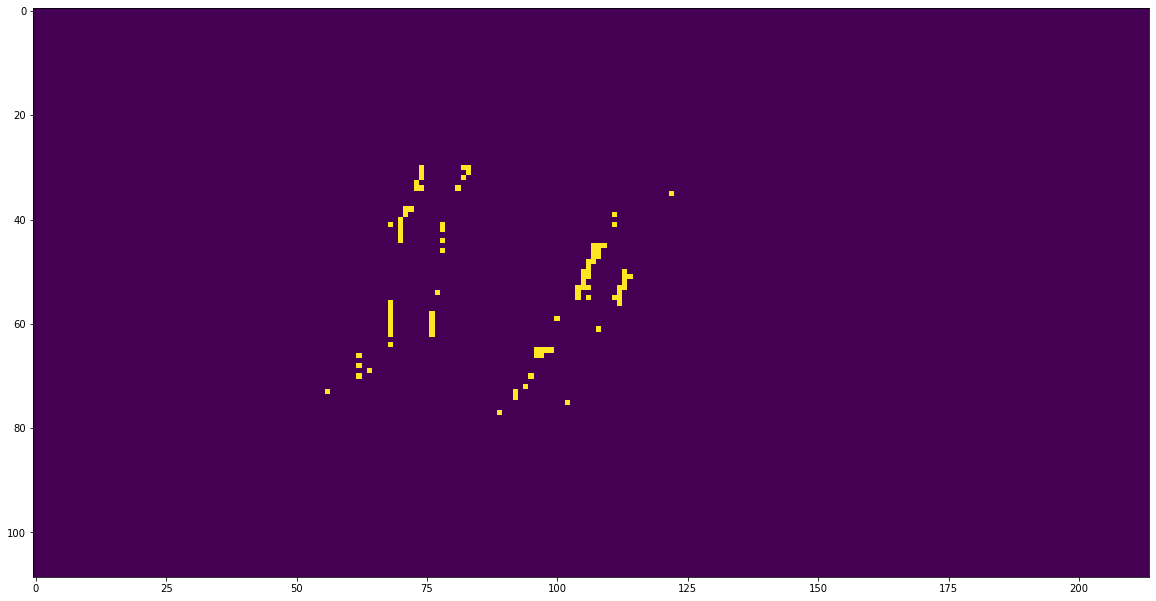

figures printed


In [561]:

asyncio.create_task(f())
button